 Notebook color scheme 

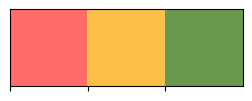

In [31]:
from typing import Any, List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import lightning.pytorch as pl
import torchvision
import torchmetrics
import albumentations
import wandb
import os
import sys
import warnings 
import json
import gc


from PIL import Image
from sklearn.model_selection import train_test_split

from deepspeed.ops.adam import FusedAdam

from IPython.display import display_markdown, display_latex
from matplotlib.colors import ListedColormap
from rich.console import Console
from rich.progress import track
from rich.table import Table
from rich import print as rprint

from collections import defaultdict

MY_COLORS = ["#ff6b6b", "#fcbf49", "#6a994e"]
MY_COLORMAP = ListedColormap(MY_COLORS)

WANDB_CONFIG = {"experiment":"GSoc2023", "_wandb_kernel":"aot"}

rprint("[bold #6a994e] Notebook color scheme [/bold #6a994e]")
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()

In [2]:
api_key = os.environ["WANDB_API_KEY"]
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: /home/darthvader/.netrc


# Create MetaData

In [3]:
def metaCreate(root_dir:str, sub_dir:str) -> "pd.DataFrame":
    """
    This function is used to create the metaData for the files.

    :param root_dir: the root directory of the datasets.
    :param sub_dir: the sub-directory, i.e. train/val in the datasets.

    :returns: a dataframe consisting of the data paths and their corresponding labels
    """
    data = {"path":list(), "label":list()}

    for folder in os.listdir(os.path.join(root_dir, sub_dir)):
        if not folder.startswith("."):
            for files in os.listdir(os.path.join(root_dir, sub_dir, folder)):
                data["path"].append(os.path.join(root_dir, sub_dir, folder, files))
                data["label"].append(folder)

    data = pd.DataFrame(data)
    data = data.sample(frac=1, random_state=1234)
    return data

In [4]:
df_train = metaCreate("../data/dataset/dataset/", "train/")
df_val = metaCreate("../data/dataset/dataset/", "val/")

rprint(f"[italic #ff6b6b] Shape of the training dataframe [/italic #ff6b6b]: {df_train.shape}")
rprint(f"[italic #fcbf49] Shape of the validation dataframe [/italic #fcbf49]: {df_val.shape}")

 Shape of the training dataframe : (30000, 2)

 Shape of the validation dataframe : (7500, 2)

In [5]:
def print_table(data:"pd.DataFrame", head:Optional[int]=5, title:Optional[str]="Title") -> None:
    """
    This function is used for pretty printing pandas dataframe

    :param data: a dataframe which needs to be pretty printed.
    :param head: the number of rows to print of the dataframe.
    :param title: a title to give the table.

    """

    data = data.head(head)

    table = Table(title=title)
    table.add_column("Image Paths", justify="right", style=MY_COLORS[2], no_wrap=True)
    table.add_column("Label", justify="center", style=MY_COLORS[1])

    for row in data.iterrows():
        table.add_row(row[1][0], row[1][1])

    console = Console()
    console.rule(f"[bold {MY_COLORS[0]}] {title}")
    console.print(table)

print_table(df_train, head=5, title="Training Data")
print_table(df_val, head=5, title="Validation Data")

─────────────────────────────────────────────────  Training Data ──────────────────────────────────────────────────

                     Training Data                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃                                 Image Paths ┃ Label ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│   ../data/dataset/dataset/train/no/3566.npy │  no   │
│    ../data/dataset/dataset/train/no/951.npy │  no   │
│    ../data/dataset/dataset/train/no/530.npy │  no   │
│ ../data/dataset/dataset/train/vort/1819.npy │ vort  │
│ ../data/dataset/dataset/train/vort/6170.npy │ vort  │
└─────────────────────────────────────────────┴───────┘

────────────────────────────────────────────────  Validation Data ─────────────────────────────────────────────────

                    Validation Data                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                 Image Paths ┃ Label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│    ../data/dataset/dataset/val/vort/687.npy │  vort  │
│       ../data/dataset/dataset/val/no/90.npy │   no   │
│     ../data/dataset/dataset/val/no/2370.npy │   no   │
│ ../data/dataset/dataset/val/sphere/2234.npy │ sphere │
│      ../data/dataset/dataset/val/no/374.npy │   no   │
└─────────────────────────────────────────────┴────────┘

# Create DataLoaders

In [6]:
LABELS2IDX = {k:v for v, k in enumerate(df_train['label'].unique())}
IDX2LABELS = {v:k for k, v in LABELS2IDX.items()}


class LensDataset(td.Dataset):
    def __init__(self, data: "pd.DataFrame", resize: Optional[Tuple] = None, 
                 resampling: Optional["Image.Resampling"] = Image.Resampling.BILINEAR,
                 transformations: Optional["albumentations.Compose"] = None):
        
        self.data = data
        self.resize = resize
        self.resampling = resampling
        self.transformations = transformations

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int) -> Dict:
        
        path = self.data.iloc[index]["path"]
        label = self.data.iloc[index]["label"]

        img = np.load(path)
        img = np.transpose(img, (2, 1, 0)) # Converting to CHW to HWC for resizing and transformations
        
        img = Image.fromarray(img.squeeze(axis=-1))
        
        if self.resize is not None:
            img = img.resize((self.resize[0], self.resize[1]), resample=self.resampling)
        
        img = np.array(img)
        img = np.expand_dims(img, -1) # Converting from (h, w) -> (h, w, 1) where 1 indicates a greyscale channel image
        img = img.repeat(3, axis=-1) # Converting from a single channel i.e. (h, w) -> (h, w, 3)
        
        if self.transformations is not None:
            transform = self.transformations(image=img)
            img = transform["image"]

        
        img = np.transpose(img, (2, 0, 1)).astype(np.float32) # Converting back to CHW from HWC 

        return {
            "img" : torch.tensor(img, dtype=torch.float),
            "label" : torch.tensor(LABELS2IDX[label], dtype=torch.long)
        }

In [7]:
class LitLensDataset(pl.LightningDataModule):
    def __init__(self, data: "pd.DataFrame", resize: Optional[Tuple]=None, 
                 resampling: Optional["Image.Resampling"] = Image.Resampling.BILINEAR,
                 transformations: Optional["albumentations.Compose"]=None, batch_sz: Optional[int]=64):
        self.data = data
        self.resize = resize
        self.resampling = resampling
        self.transformations = transformations
        self.batch_sz = batch_sz

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage: Optional[str]="train"):
        
        if stage not in ["train", "val", "test"]:
            raise Exception(f"Expected stage to be either of the two 'train/val/test'. Found {stage}.")
        
        if stage == "train":
            self.train = LensDataset(self.data, resize=self.resize, resampling = self.resampling, transformations=self.transformations)
        
        elif stage == "val":
            self.val = LensDataset(self.data, resize=self.resize, resampling = self.resampling, transformations=self.transformations)

        else:
            self.test = LensDataset(self.data, resize=self.resize, resampling = self.resampling, transformations=self.transformations)


    def train_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.train, batch_size=self.batch_sz, shuffle=True, 
                             num_workers=4, pin_memory=True)
    
    def val_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.val, batch_size=self.batch_sz, shuffle=False, 
                             num_workers=4, pin_memory=True)

    def test_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.test, batch_size=self.batch_sz, shuffle=False, 
                             num_workers=4, pin_memory=True)

# Model

In [17]:
class LitClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, model_name: str, lr: Optional[float]=1e-4, min_lr: Optional[float]=1e-6, weight_decay: Optional[float]=1e-6,
                wandb_log: Optional["wandb.Api"] = None, freeze_layers: Optional[bool] = True):

        super().__init__()
        
        if model_name not in ["resnet", "effnet"]:
            raise Exception(f"Expected model_name to be either resnet/effnet. Found {model_name}")
            
        self.model_name = model_name
        
        if model_name == "resnet":
            self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Identity()
            
        else:
            self.model = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1)
            self.model.classifier[-1] = nn.Identity()
            
        if freeze_layers:
            for param in self.model.parameters():
                param.requires_grad = False
            
        self.classifier = nn.LazyLinear(out_features=n_classes)

        self.train_res = dict(acc=list(), f1=list(), aucroc=list())
        self.val_res = dict(acc=list(), f1=list(), aucroc=list())
        self.test_res = dict(acc=list(), f1=list(), aucroc=list(), loss=list())

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        
        self.wandb_log = wandb_log
        
        self.accScore = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average="weighted")
        self.f1Score = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average='weighted')
        self.auc_roc = torchmetrics.AUROC(task="multiclass", num_classes=n_classes)

        self.save_hyperparameters('lr', 'min_lr', 'weight_decay')

    def forward(self, x: "torch.Tensor"):
        feats = self.model(x)
        logits = self.classifier(feats)

        return logits
    
    def compute_loss(self, logits: "torch.Tensor", y: "torch.Tensor") -> "torch.Tensor":
        return F.cross_entropy(logits, y)
    

    def compute_metrics(self, logits: "torch.Tensor", y:"torch.Tensor") -> Dict:
        
        yhat = torch.argmax(logits, dim=-1)

        return {
            'accScore' : self.accScore(yhat, y),
            'f1Score' : self.f1Score(yhat, y),
            'aucrocScore' : self.auc_roc(F.softmax(logits, dim=1), y)
        }

    
    def training_step(self, batch, batch_idx):
        x, y = batch["img"], batch["label"]
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.train_res['acc'].append(metrics['accScore'])
        self.train_res['f1'].append(metrics['f1Score'])
        self.train_res['aucroc'].append(metrics['aucrocScore'])

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        
        if self.wandb_log is not None:
            self.wandb_log.log({"train/loss" : loss})

        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch["img"], batch["label"]
        
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.val_res['acc'].append(metrics['accScore'])
        self.val_res['f1'].append(metrics['f1Score'])
        self.val_res['aucroc'].append(metrics['aucrocScore'])

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        
        if self.wandb_log is not None:
            self.wandb_log.log({"val/loss" : loss})        

        return loss        
    
    def test_step(self, batch, batch_idx):

        x, y = batch["img"], batch["label"]
        
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.test_res['acc'].append(metrics['accScore'])
        self.test_res['f1'].append(metrics['f1Score'])
        self.test_res['aucroc'].append(metrics['aucrocScore'])
        self.test_res['loss'].append(loss)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)

        return loss           
    

    def on_train_epoch_end(self):

        all_acc = torch.stack(self.train_res['acc']).mean()
        all_f1 = torch.stack(self.train_res['f1']).mean()
        all_aucroc = torch.stack(self.train_res['aucroc']).mean()

        self.log('train_acc', all_acc, logger=True)
        self.log('train_f1', all_f1, logger=True)
        self.log('train_aucroc', all_aucroc, logger=True)
        
        self.train_res['acc'].clear()
        self.train_res['f1'].clear()
        self.train_res['aucroc'].clear()
        
        if self.wandb_log is not None:
            self.wandb_log.log({'train/Accuracy': all_acc})
            self.wandb_log.log({'train/F1Score' : all_f1})
            self.wandb_log.log({'train/AUCROC' : all_aucroc})


    def on_validation_epoch_end(self):


        all_acc = torch.stack(self.val_res['acc']).mean()
        all_f1 = torch.stack(self.val_res['f1']).mean()
        all_aucroc = torch.stack(self.val_res['aucroc']).mean()

        self.log('val_acc', all_acc, logger=True)
        self.log('val_f1', all_f1, logger=True)
        self.log('val_aucroc', all_aucroc, logger=True)
        
        self.val_res['acc'].clear()
        self.val_res['f1'].clear()
        self.val_res['aucroc'].clear()
        
        if self.wandb_log is not None:
            self.wandb_log.log({'val/Accuracy': all_acc})
            self.wandb_log.log({'val/F1Score' : all_f1})
            self.wandb_log.log({'val/AUCROC' : all_aucroc})        
        
        
    def on_test_epoch_end(self):


        all_acc = torch.stack(self.test_res['acc']).mean()
        all_f1 = torch.stack(self.test_res['f1']).mean()
        all_aucroc = torch.stack(self.test_res['aucroc']).mean()
        all_loss = torch.stack(self.test_res['loss']).mean()

        self.log('test_acc', all_acc, logger=True)
        self.log('test_f1', all_f1, logger=True)
        self.log('test_aucroc', all_aucroc, logger=True)
        self.log('test_loss', all_loss, logger=True)
        
        self.test_res['acc'].clear()
        self.test_res['f1'].clear()    
        self.test_res['aucroc'].clear()
        self.test_res['loss'].clear()
        
        return {
            "accuracy" : all_acc,
            "f1Score" : all_f1,
            "aucroc" : all_aucroc, 
            "loss" : all_loss
        }


    def configure_optimizers(self) -> Dict:
        
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)    
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, eta_min=self.min_lr)

        return {
            "optimizer" : optimizer,
            "lr_scheduler" : scheduler
        }

# Create DataLoaders

In [18]:
train_data, minival_data = train_test_split(df_train, shuffle=True, test_size=.25, random_state=42, stratify=df_train['label'])

rprint(f"[bold #ff6b6b] Shape of the training data[/bold #ff6b6b] : {train_data.shape}")
rprint(f"[bold #6a994e] Shape of the validation data[/bold #6a994e] : {minival_data.shape}")

 Shape of the training data : (22500, 2)

 Shape of the validation data : (7500, 2)

# Define Model and Trainer

In [19]:
def model_training(train_data: "pd.DataFrame", val_data: "pd.DataFrame", 
                   model_name: str, chkpt_dir: Optional[str]='./checkpoints', 
                   chkpt_filename: Optional['str']='best_chkpt', 
                   early_stop_patience: Optional[int]=3,
                   wandb_log: Optional["wandb.Api"]=None, 
                   freeze_layers: Optional[bool]=True, **kwargs) -> None:
    """
    This function is used to train a model using pytorch lightning
    
    :params train_dl: the training dataloader.
    :params val_dl: the validation dataloader.
    :params model_name: The name of the model that has to be trained.
    :params chkpt_dir: the directory to save the checkpoints.
    :params chkpt_filename: the best checkpoint filename.
    :params early_stop_patience: the number of epochs to wait before early stopping.
    :params wandb_log: the wandb logging api
    
    :returns: None
    """
    
    if not os.path.exists(chkpt_dir):
        os.mkdir(chkpt_dir)
    
    torch.cuda.empty_cache()
    
    train_dm, train_dl, val_dm, val_dl = None, None, None, None
    
    train_transformations = albumentations.Compose([
        albumentations.RandomBrightnessContrast(),
        albumentations.Rotate(),
        albumentations.CenterCrop(224, 224, always_apply=True),
        albumentations.Normalize(always_apply=True, max_pixel_value=1.),
    ])

    val_transformations = albumentations.Compose([
        albumentations.CenterCrop(224, 224, always_apply=True),
        albumentations.Normalize(always_apply=True, max_pixel_value=1.)
    ])    
    
    
    train_dm = LitLensDataset(train_data, resize=(256, 256), transformations=train_transformations)
    val_dm = LitLensDataset(val_data, resize=(256, 256), transformations=val_transformations)

    train_dm.setup(stage="train")
    val_dm.setup(stage="val")

    train_dl = train_dm.train_dataloader()
    val_dl = val_dm.val_dataloader()
        
        
    
    model = LitClassifier(3, model_name, wandb_log = wandb_log, freeze_layers=freeze_layers)
    
    early_stop = pl.callbacks.EarlyStopping(monitor="val_aucroc", mode="max", patience=early_stop_patience, verbose=True)
    model_check = pl.callbacks.ModelCheckpoint(dirpath=chkpt_dir, filename=chkpt_filename, 
                                               monitor="val_aucroc", mode="max", save_top_k=1, save_on_train_epoch_end=False)
    
    prog_bar = pl.callbacks.RichProgressBar()
    
    trainer = pl.Trainer(accelerator="gpu", 
                         devices=1, 
                         precision=16, 
                         max_epochs=10000, 
                         callbacks=[early_stop, model_check, prog_bar], **kwargs)
    
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    del model
    del trainer
    del early_stop
    del model_check
    del prog_bar
    
    del train_dm
    del train_dl
    del val_dm
    del val_dl
    del train_transformations
    del val_transformations
    gc.collect()
    

In [11]:
run = wandb.init(project="GSOC23-Task1", name="resnet50", config=WANDB_CONFIG)
model_training(train_data, minival_data, "resnet", chkpt_filename="best_resnet_checkpoint", wandb_log=run, freeze_layers=False)

wandb: Currently logged in as: lmorningstar. Use `wandb login --relogin` to force relogin


/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read ht

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model      │ ResNet             │ 23.5 M │
│ 1 │ classifier │ LazyLinear         │      0 │
│ 2 │ accScore   │ MulticlassAccuracy │      0 │
│ 3 │ f1Score    │ MulticlassF1Score  │      0 │
│ 4 │ auc_roc    │ MulticlassAUROC    │      0 │
└───┴────────────┴────────────────────┴────────┘

Trainable params: 23.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94

Output()

Metric val_aucroc improved. New best score: 0.915
Metric val_aucroc improved by 0.048 >= min_delta = 0.0. New best score: 0.963
Metric val_aucroc improved by 0.014 >= min_delta = 0.0. New best score: 0.977
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.978
Metric val_aucroc improved by 0.005 >= min_delta = 0.0. New best score: 0.984
Metric val_aucroc improved by 0.002 >= min_delta = 0.0. New best score: 0.986
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.988
Metric val_aucroc improved by 0.002 >= min_delta = 0.0. New best score: 0.989
Monitored metric val_aucroc did not improve in the last 3 records. Best score: 0.989. Signaling Trainer to stop.


In [12]:
wandb.finish()

train/AUCROC,▁▇▇▇████████████
train/Accuracy,▁▆▇▇▇▇▇▇████████
train/F1Score,▁▆▇▇▇▇▇█████████
train/loss,█▆▄▃▃▃▂▂▃▂▂▃▂▂▂▁▂▁▂▂▃▁▂▃▃▂▂▃▂▁▁▁▂▁▁▃▂▂▁▁
val/AUCROC,▁▇███████████████
val/Accuracy,▁▆▇██████████████
val/F1Score,▁▇▇██████████████
val/loss,█▇█▅▅▅▅▅▂▃▄▃▆▄▅▃▃▄▃▂▂▂▃▂▂▄▄▂▂▆▅▃▁▆▄▃▃▂▄▂
train/AUCROC,0.99006
train/Accuracy,0.93253
train/F1Score,0.93255


In [21]:
run = wandb.init(project="GSOC23-Task1", name="effnet", config=WANDB_CONFIG)
model_training(train_data, minival_data, "effnet", chkpt_filename="best_effnet_checkpoint", wandb_log=run, freeze_layers=False)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model      │ EfficientNet       │  7.7 M │
│ 1 │ classifier │ LazyLinear         │      0 │
│ 2 │ accScore   │ MulticlassAccuracy │      0 │
│ 3 │ f1Score    │ MulticlassF1Score  │      0 │
│ 4 │ auc_roc    │ MulticlassAUROC    │      0 │
└───┴────────────┴────────────────────┴────────┘

Trainable params: 7.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.7 M                                                                                                
Total estimated model params size (MB): 30

Output()

Metric val_aucroc improved. New best score: 0.717
Metric val_aucroc improved by 0.147 >= min_delta = 0.0. New best score: 0.864
Metric val_aucroc improved by 0.053 >= min_delta = 0.0. New best score: 0.917
Metric val_aucroc improved by 0.025 >= min_delta = 0.0. New best score: 0.943
Metric val_aucroc improved by 0.015 >= min_delta = 0.0. New best score: 0.958
Metric val_aucroc improved by 0.005 >= min_delta = 0.0. New best score: 0.963
Metric val_aucroc improved by 0.006 >= min_delta = 0.0. New best score: 0.969
Metric val_aucroc improved by 0.007 >= min_delta = 0.0. New best score: 0.977
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.978
Metric val_aucroc improved by 0.002 >= min_delta = 0.0. New best score: 0.980
Metric val_aucroc improved by 0.000 >= min_delta = 0.0. New best score: 0.980
Metric val_aucroc improved by 0.000 >= min_delta = 0.0. New best score: 0.981
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.982
Metric val_auc

In [22]:
wandb.finish()

train/AUCROC,▁▄▆▇▇▇▇▇████████████████████
train/Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇██████████████
train/F1Score,▁▃▅▆▆▆▇▇▇▇▇▇▇▇██████████████
train/loss,██▇▅▆▄▄▃▂▃▃▂▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▃▂▂▂▂▂▂▂▁▁▂▂▂
val/AUCROC,▁▄▆▇▇████████████████████████
val/Accuracy,▁▃▅▆▇▇▇▇▇████████████████████
val/F1Score,▁▃▆▆▇▇▇▇▇████████████████████
val/loss,▇█▆▅▆▃▄▄▃▃▃▂▂▃▃▂▂▂▃▄▃▂▂▁▂▂▃▂▁▂▂▂▃▁▂▁▂▃▂▃
train/AUCROC,0.99029
train/Accuracy,0.9323
train/F1Score,0.93227


In [28]:
def model_testing(data: "pd.DataFrame", model_name: str, chkpt_path: str) -> None:
    """
    This function is used to test our model.
    
    :param data: Represents the test dataset
    :param model_name: Represents the model name 
    :param chkpt_path: Represents the trained model saved path
    
    :returns: None
    """
    
    transformations = albumentations.Compose([
        albumentations.CenterCrop(224, 224, always_apply=True),
        albumentations.Normalize(always_apply=True, max_pixel_value=1.)
    ])
    
    test_dm = LitLensDataset(data, resize=(256, 256), resampling=Image.Resampling.BILINEAR, 
                             transformations=transformations, batch_sz=128)
    
    test_dm.setup(stage="test")
    test_dl = test_dm.test_dataloader()
    
    trained_model = LitClassifier.load_from_checkpoint(chkpt_path, n_classes=3, model_name=model_name)
    trained_model.freeze()
    
    trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[pl.callbacks.RichProgressBar()])
    test_res = trainer.test(trained_model, dataloaders=test_dl)
    
    with open(f'./results/{model_name}_results.json', 'w') as fp:
        json.dump(test_res, fp)

In [29]:
model_testing(df_val, 'resnet', './checkpoints/best_resnet_checkpoint-v3.ckpt')

/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9297223687171936     │
│        test_aucroc        │    0.9869203567504883     │
│          test_f1          │    0.9295058250427246     │
│         test_loss         │    0.20070190727710724    │
└───────────────────────────┴───────────────────────────┘

In [30]:
model_testing(df_val, 'effnet', './checkpoints/best_effnet_checkpoint-v1.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9350119829177856     │
│        test_aucroc        │    0.9883600473403931     │
│          test_f1          │    0.9349082112312317     │
│         test_loss         │    0.20905472338199615    │
└───────────────────────────┴───────────────────────────┘

# Comparisons

In [37]:
results = defaultdict(lambda : list())

for res_files in os.listdir('./results/'):
    if res_files.startswith('.'):
        continue
        
    with open(os.path.join('./results', res_files)) as fp:
        data = json.load(fp)
        results['model_name'].append(res_files.split("_")[0])
        for keys, values in data[0].items():
            results[keys].append(values)

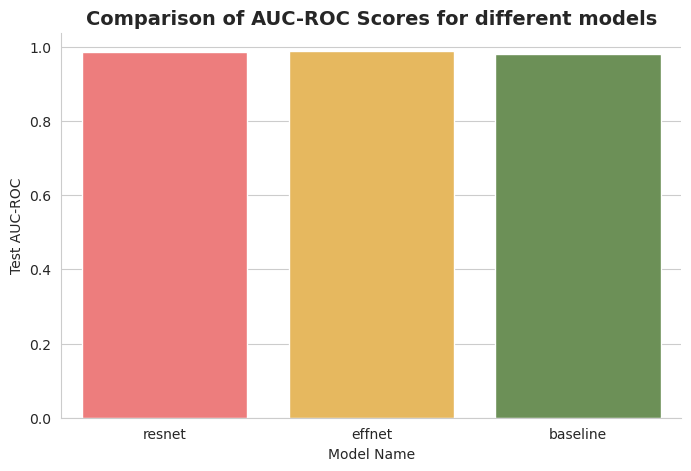

In [50]:
results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
plt.title("Comparison of AUC-ROC Scores for different models", weight="bold", fontsize=14)
sns.barplot(x="model_name", y="test_aucroc", data=results, palette=MY_COLORS)
plt.xlabel("Model Name")
plt.ylabel("Test AUC-ROC")
sns.despine()
plt.show()